In [1]:
import os
os.chdir('XXX') #path to your folder

In [ ]:
import pickle 
import numpy as np

# Load ABIDE-150 data with 80 dimensional dictionary elements 
data_dict = pickle.load(open( "./preprocess_scripts/abide_dl_80_data.pkl", "rb"))
ys = data_dict['ys'] - 1
xs = data_dict['zs'] # Dictionary learning loadings treated as data

In [ ]:
import torch

def get_samples(xs, ys):
    classes = [0, 1]
    anchors = []
    positives = []
    negatives = []

    for c in classes:
        # construct anchors from batch
        anchors.append(torch.tensor(xs[ys == c].reshape(-1, xs.shape[-1])).float())
        
        # pick postive samples randomly from dataset
        pos_idx = torch.randint(0, len(xs[ys == c]), (len(anchors[-1]),))
        positives.append(torch.tensor(xs[ys == c].reshape(-1, xs.shape[-1]))[pos_idx].float())
        
        # pick negative samples randomly from dataset
        neg_idx = torch.randint(0, len(xs[ys != c]), (len(anchors[-1]),))
        negatives.append(torch.tensor(xs[ys != c].reshape(-1, xs.shape[-1]))[neg_idx].float())

    anchors = torch.vstack(anchors)
    positives = torch.vstack(positives)
    negatives = torch.vstack(negatives)

    return anchors, positives, negatives

In [4]:
from utils.eval import get_eval_metrics, get_cv_metrics
from sklearn.neighbors import KNeighborsClassifier
from collections import Counter
    
def get_knn_metrics(encoder, xs_train, ys_train, xs_test, ys_test, z_dim):    
    
    #Option to run it with cuda
    #zs_train = encoder(torch.tensor(xs_train.reshape(-1, xs_train.shape[-1])).float().cuda()).detach().cpu()
    #zs_train = zs_train.reshape(xs_train.shape[0], xs_train.shape[1], z_dim)

    #zs_test = encoder(torch.tensor(xs_test.reshape(-1, xs_test.shape[-1])).float().cuda()).detach().cpu()
    #zs_test = zs_test.reshape(xs_test.shape[0], xs_test.shape[1], z_dim)
    
    zs_train = encoder(torch.tensor(xs_train.reshape(-1, xs_train.shape[-1])).float()).detach()
    zs_train = zs_train.reshape(xs_train.shape[0], xs_train.shape[1], z_dim)
    
    zs_test = encoder(torch.tensor(xs_test.reshape(-1, xs_test.shape[-1])).float()).detach()
    zs_test = zs_test.reshape(xs_test.shape[0], xs_test.shape[1], z_dim)
    
    
    # Trian k-NN classifier
    neigh = KNeighborsClassifier(n_neighbors=3, metric='cosine')
    neigh.fit(zs_train.reshape(-1, z_dim), np.tile(ys_train[:,None], (1, xs_train.shape[1])).reshape(-1))
    
    # Use k-NN to classify each volume
    # then use majority vote to classify each sequence
    y_train_pred = []
    for z in zs_train:
        c = Counter(neigh.predict(z))
        value, count = c.most_common()[0]
        y_train_pred.append(value)
    
    train_metrics = get_eval_metrics(ys_train, y_train_pred)
    
    # Repeat for held-out data
    y_test_pred = []
    for z in zs_test:
        c = Counter(neigh.predict(z))
        value, count = c.most_common()[0]
        y_test_pred.append(value)

    test_metrics = get_eval_metrics(ys_test, y_test_pred)

    return train_metrics, test_metrics

In [5]:
X_DIM = 80
Z_DIM = 10

N_SPLITS = 5

LMBDA = 0 # Weight on reconstruction error term
M = 20
N_EPOCHS = 40
LR = 0.001
SUB_PER_BATCH = 30
DROPOUT = .3

USE_CUDA = True
TEST_MODE = True

In [6]:
from torch import nn
import torch.nn.functional as F

class Encoder(nn.Module):
    def __init__(self, x_dim, z_dim, dropout):
        super(Encoder, self).__init__()
        self.nonlinearity = nn.Softplus()
        self.dropout = nn.Dropout(dropout)
        
        self.fc1 = nn.Linear(x_dim, 50)
        self.fc2 = nn.Linear(50, 20)
        self.fc3 = nn.Linear(20, z_dim)
        
        
    def forward(self, x):
        x = self.dropout(self.nonlinearity(self.fc1(x)))
        x = self.dropout(self.nonlinearity(self.fc2(x)))
        x = self.fc3(x)
        
        return x
    
class Decoder(nn.Module):
    def __init__(self, x_dim, z_dim, dropout):
        super(Decoder, self).__init__()
        self.nonlinearity = nn.Softplus()
        
        self.fc1 = nn.Linear(z_dim, 50)
        self.fc2 = nn.Linear(50, 100)
        self.fc3 = nn.Linear(100, 200)
        self.fc4 = nn.Linear(200, x_dim)
        
    def forward(self, x):
        x = self.nonlinearity(self.fc1(x))
        x = self.nonlinearity(self.fc2(x))
        x = self.nonlinearity(self.fc3(x))
        x = self.fc4(x)

        return x    

In [7]:
from sklearn.model_selection import StratifiedKFold
import torch.optim as optim

losses = []
ho_losses = []
train_metrics_lst = []
test_metrics_lst = []
cached_anchors = []

recon_losses = []
ho_recon_losses = []
info_losses = []
ho_info_losses = []

device = torch.device("cuda" if USE_CUDA else "cpu")

def compute_loss(encoder, decoder, xs, ys):
    loss = 0.0
        
    anchors, positives, negatives = get_samples(xs, ys)
    #a, p, n = encoder(anchors.cuda()), encoder(positives.cuda()), encoder(negatives.cuda())
    a, p, n = encoder(anchors), encoder(positives), encoder(negatives)

    a = torch.nn.functional.normalize(a, p=2.0, dim = 1)
    p = torch.nn.functional.normalize(p, p=2.0, dim = 1)
    n = torch.nn.functional.normalize(n, p=2.0, dim = 1)

    # alpha - log(exp(alpha) + beta)
    # alpha = z_anchor^T z_positive
    # beta = sum_m exp(z_anchor^T z^negative)
    alpha = torch.sum(a * p, 1)

    beta = torch.exp(torch.sum(a * n, 1))
    for _ in range(M):
        perm = torch.randperm(n.size(0))
        beta = beta + torch.exp(torch.sum(a * n[perm], 1))

    info_loss = -1 * torch.mean(alpha - torch.log(torch.exp(alpha) + beta))
    #recon_loss = torch.mean(torch.norm(anchors.cuda() - decoder(a), p=2,  dim=1)**2)
    recon_loss = torch.mean(torch.norm(anchors - decoder(a), p=2,  dim=1)**2)
    
    return info_loss, recon_loss

kf = StratifiedKFold(n_splits=N_SPLITS)

for i, (train_index, test_index) in enumerate(kf.split(xs, ys)):
    if TEST_MODE and i > 0:
        print('!!!TEST MODE!!!')
        break

    # Initialize neural net and optimizer
    #encoder = Encoder(x_dim=X_DIM, z_dim=Z_DIM, dropout=DROPOUT).to(device)
    #decoder = Decoder(x_dim=X_DIM, z_dim=Z_DIM, dropout=DROPOUT).to(device)
    encoder = Encoder(x_dim=X_DIM, z_dim=Z_DIM, dropout=DROPOUT)
    decoder = Decoder(x_dim=X_DIM, z_dim=Z_DIM, dropout=DROPOUT)

    learnable_params = list(encoder.parameters()) + list(decoder.parameters())
    optimizer = optim.Adam(learnable_params, lr=LR)

    losses.append([])
    ho_losses.append([])
    train_metrics_lst.append([])
    test_metrics_lst.append([])
    recon_losses.append([])
    ho_recon_losses.append([])
    info_losses.append([])
    ho_info_losses.append([])


    print(f'\nFold {i+1} of {N_SPLITS}')
    xs_train, xs_test = xs[train_index], xs[test_index]
    ys_train, ys_test = ys[train_index], ys[test_index]

    
    for i in range(N_EPOCHS):
        if i % 1 == 0:
            print(f'\rEpoch: {i+1} of {N_EPOCHS}', end="")
            train_metrics, test_metrics = get_knn_metrics(encoder, xs_train, ys_train, xs_test, ys_test, z_dim=Z_DIM)
            
            train_metrics_lst[-1].append(train_metrics)
            test_metrics_lst[-1].append(test_metrics)            

            #print(train_metrics)
            #print(test_metrics)
            #print(f'Recon Loss: {recon_loss}; Info Loss: {info_loss}')
            #print(f'HO Recon Loss: {ho_recon_loss}; HO Info Loss: {ho_info_loss}')

        
        for batch in range(int(xs_train.shape[0]/SUB_PER_BATCH)):
            permutation = torch.randperm(xs_train.shape[0])[:SUB_PER_BATCH]

            # Train step
            optimizer.zero_grad()
            encoder.train()
            decoder.train()

            info_loss, recon_loss = compute_loss(encoder, decoder, xs_train[permutation], ys_train[permutation])
            loss = (1.-LMBDA) * info_loss + LMBDA * recon_loss

            loss.backward()
            optimizer.step()
            losses[-1].append(loss.item())

            # Eval on heldout
            encoder.eval()
            decoder.eval()
            ho_info_loss, ho_recon_loss = compute_loss(encoder, decoder, xs_test, ys_test)
            loss = (1.-LMBDA) * ho_info_loss + LMBDA * ho_recon_loss
            ho_losses[-1].append(loss.item())

            #recon_losses[-1].append(recon_loss.detach().cpu())
            #ho_recon_losses[-1].append(ho_recon_loss.detach().cpu())
            #info_losses[-1].append(info_loss.detach().cpu())
            #ho_info_losses[-1].append(ho_info_loss.detach().cpu())
            
            recon_losses[-1].append(recon_loss.detach())
            ho_recon_losses[-1].append(ho_recon_loss.detach())
            info_losses[-1].append(info_loss.detach())
            ho_info_losses[-1].append(ho_info_loss.detach())
            
            
            # Save for visualization
            #if i % 50 == 0:
            #    cached_anchors.append(net(torch.tensor(xs_train).cuda().float()).detach().cpu().numpy())
            #    cached_labels.append(ys)

            
            



Fold 1 of 5
Epoch: 40 of 40!!!TEST MODE!!!


In [8]:
cv_results = [t[-1] for t in train_metrics_lst]

metrics = get_cv_metrics(cv_results)
vals = list(metrics.values())
print('--------------------- Train [Acc/Sen/Spec] ---------------------')
print(f'\t{vals[0]:.3f}\u00B1{vals[1]:.3f}' +
      f'\t{vals[2]:.3f}\u00B1{vals[3]:.3f}' +
      f'\t{vals[4]:.3f}\u00B1{vals[5]:.3f}')

cv_results = [t[-1] for t in test_metrics_lst]

metrics = get_cv_metrics(cv_results)
vals = list(metrics.values())
print('\n--------------------- Test [Acc/Sen/Spec] ---------------------')
print(f'\t{vals[0]:.3f}\u00B1{vals[1]:.3f}' +
      f'\t{vals[2]:.3f}\u00B1{vals[3]:.3f}' +
      f'\t{vals[4]:.3f}\u00B1{vals[5]:.3f}')

--------------------- Train [Acc/Sen/Spec] ---------------------
	1.000±0.000	1.000±0.000	1.000±0.000

--------------------- Test [Acc/Sen/Spec] ---------------------
	0.800±0.000	0.600±0.000	1.000±0.000


### Visualization

In [9]:
from matplotlib import pyplot as plt

In [10]:
encoder.eval()
#zs_test = encoder(torch.tensor(xs_test).cuda().float()).cpu().detach()
zs_test = encoder(torch.tensor(xs_test).float()).detach()
zs_test = zs_test.reshape(-1, Z_DIM)
ys_test_in = np.tile(ys_test[:, None], (1,78)).reshape(-1)

In [11]:
import umap.umap_ as umap
um = umap.UMAP(n_neighbors=5,
                      min_dist=0.1,
                      metric='euclidean').fit(zs_test)
embeddings = um.transform(zs_test)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [12]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=0).fit(zs_test.numpy())
cluster_means = kmeans.cluster_centers_

In [13]:
cluster_means_umap = um.transform(cluster_means)

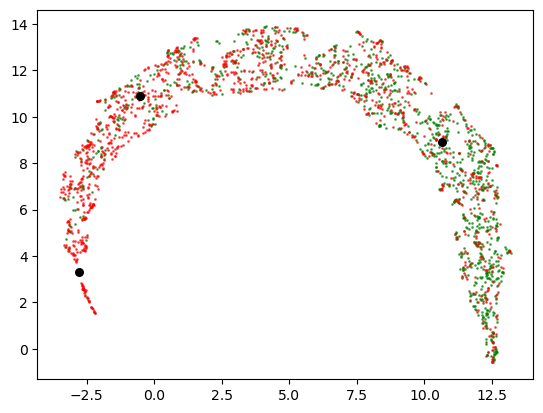

In [14]:
plt.figure()
plt.scatter(embeddings[ys_test_in==0,0], embeddings[ys_test_in==0,1], color='green', s=1, alpha=.6)
plt.scatter(embeddings[ys_test_in==1,0], embeddings[ys_test_in==1,1], color='red', s=1, alpha=.6)
plt.scatter(cluster_means_umap[:,0], cluster_means_umap[:,1], color='black', marker='o', edgecolors='black', s=30)

### Plot fMRI volume

In [15]:
# Find zs_test that is closes to the mean
# Find corresponding xs_test that is closest to the mean
# Get dictionary reconstruction
# Plot fMRI volume

In [16]:
idx = np.argmin(np.linalg.norm(cluster_means[2] - zs_test.numpy(), axis=1)**2)
xs_mean = xs_test.reshape(-1, 80)[idx]
image = xs_mean @ data_dict['dict_learner'].components_ 

In [ ]:
from nilearn.input_data import NiftiMasker
from nilearn import datasets
import numpy as np

# change the file direct if needed
rest_dataset = datasets.fetch_abide_pcp(data_dir='/mnt/disks/data/')
func_filenames = rest_dataset.func_preproc
masker = NiftiMasker(detrend=True, standardize=True, mask_strategy='template', verbose=1)
fname = func_filenames[0]
masker.fit(fname)
#fmri_data = masker.transform(fname)
fmri_data_3d = masker.inverse_transform(image)

In [ ]:
from nilearn import plotting
coords = plotting.find_xyz_cut_coords(fmri_data_3d)
display = plotting.plot_stat_map(fmri_data_3d, cut_coords=coords, colorbar=True,)

In [ ]:
# get points closest to a mean if needed
cluster_means 
# get corresponding x
# x to image space

### Cleanup Below

In [ ]:
from matplotlib import pyplot as plt
for i in range(N_SPLITS):
    plt.plot(torch.stack(info_losses[i])[15:], c='gray', alpha=.2)
    plt.plot(torch.stack(ho_info_losses[i])[15:], c='orange', alpha=.7)
    plt.legend(['info_loss', 'ho_info_loss'])
    
plt.figure()
#plt.plot([t['acc'] for t in train_metrics_lst[0]])
accs = []
for i in range(N_SPLITS):
    plt.plot([t['acc'] for t in train_metrics_lst[i]], c='gray', alpha=.2)
    plt.plot([t['acc'] for t in test_metrics_lst[i]], c='orange', linestyle='dashed', alpha=.7)


accs = []
for i in range(N_SPLITS):
    accs.append([t['acc'] for t in test_metrics_lst[i]])
plt.plot(np.stack(accs).mean(0))

plt.legend(['train acc', 'ho acc', 'mean ho acc'])

In [ ]:
from matplotlib import pyplot as plt
zs = encoder(torch.tensor(xs_test.reshape(-1, 80)).cuda().float()).detach().cpu()
ys_ = np.tile(ys_test[:,None], (1, xs_test.shape[1])).reshape(-1)

plt.subplot(1,2,1).scatter(zs[:,0][ys_==0], zs[:,1][ys_==0], c='green', alpha=0.1)
plt.subplot(1,2,2).scatter(zs[:,0][ys_==1], zs[:,1][ys_==1], c='red', alpha=0.1)

In [ ]:
from matplotlib import pyplot as plt
x_est = decoder(encoder(torch.tensor(xs_train[0][0]).cuda().float())).detach().cpu()
plt.plot(xs_train[0][0])
plt.plot(x_est)

In [ ]:
plt.scatter(zs[:,0][ys_==1], zs[:,1][ys_==1], alpha=0.1)